In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

baseline_path = Path("../reports/metrics_noq/metrics_summary.tsv")
tuned_path    = Path("../reports/hparam_tuning_noq/tuned_models_summary.tsv")

baseline = pd.read_csv(baseline_path, sep="\t")
tuned    = pd.read_csv(tuned_path,    sep="\t")

# 1) Clean up old model_base if it exists
for df in (baseline, tuned):
    if "model_base" in df.columns:
        del df["model_base"]

# 2) Create normalized model key
tuned["model_base"]    = tuned["model"].str.replace("_tuned$", "", regex=True)
baseline["model_base"] = baseline["model"]

# 3) Drop original 'model' columns to avoid suffix conflict
for df in (baseline, tuned):
    if "model" in df.columns:
        del df["model"]

# 4) Merge on model_base
merged = baseline.merge(
    tuned,
    on="model_base",
    suffixes=("_base", "_tuned"),
)

# 5) Nice display name
merged["model_name"] = merged["model_base"]

# 6) Sort by tuned F1
merged = merged.sort_values("test_f1_tuned", ascending=False).reset_index(drop=True)

merged[[
    "model_name",
    "test_f1_base", "test_roc_auc_base",
    "test_f1_tuned", "test_roc_auc_tuned"
]]

,model_name,test_f1_base,test_roc_auc_base,test_f1_tuned,test_roc_auc_tuned
0,gradient_boosting,0.776801,0.848525,0.779651,0.853049
1,catboost,0.777290,0.849048,0.779646,0.853743
2,bagging_trees,0.775569,0.850347,0.777987,0.853984
3,random_forest,0.772096,0.846966,0.777088,0.852546
4,lightgbm,0.775950,0.850709,0.776713,0.852386
5,extra_trees,0.766431,0.834252,0.775964,0.850915
6,xgboost,0.776739,0.849498,0.773995,0.848978
7,mlp,0.754378,0.828501,0.755938,0.826161
8,logreg_l2,0.753975,0.828504,0.752591,0.826313
9,linear_svm_calibrated,0.753823,0.828783,0.752252,0.825846


BEFORE AND AFTER HYPERTUNING

/var/folders/sj/r5b1vnb91cjffx5_zt6rs8v80000gn/T/ipykernel_75919/1380312607.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
/var/folders/sj/r5b1vnb91cjffx5_zt6rs8v80000gn/T/ipykernel_75919/1380312607.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")


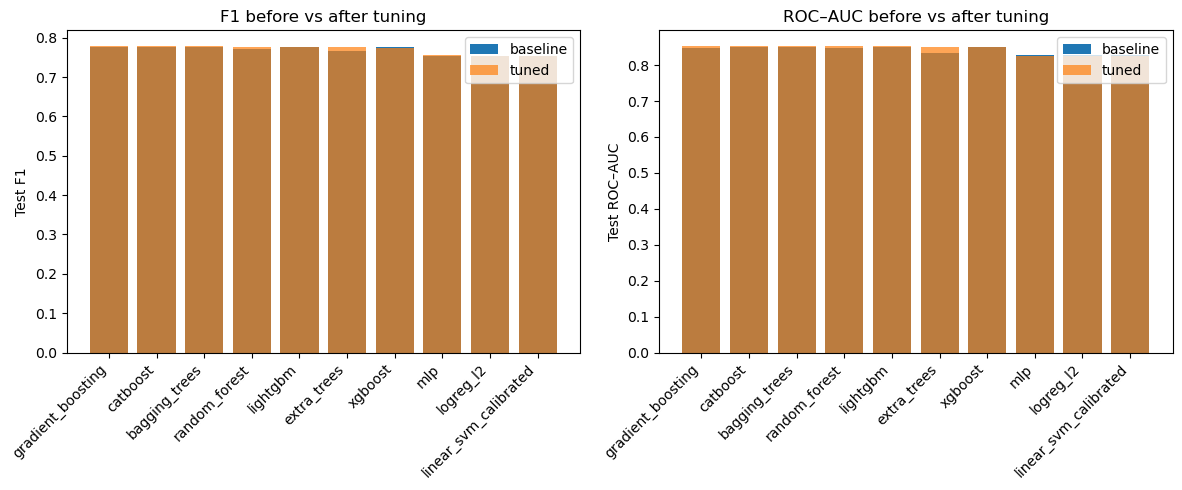

In [4]:
import matplotlib.pyplot as plt

# Use the merged you already computed
plot_df = merged.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# 1) F1
axes[0].bar(plot_df["model_name"], plot_df["test_f1_base"], label="baseline")
axes[0].bar(plot_df["model_name"], plot_df["test_f1_tuned"],
            alpha=0.7, label="tuned")
axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[0].set_ylabel("Test F1")
axes[0].set_title("F1 before vs after tuning")
axes[0].legend()

# 2) ROC–AUC
axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_base"], label="baseline")
axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_tuned"],
            alpha=0.7, label="tuned")
axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[1].set_ylabel("Test ROC–AUC")
axes[1].set_title("ROC–AUC before vs after tuning")
axes[1].legend()

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import load

from mitochime.hyperparam_search_top import load_dataset

# 1) Load test set (ablated / no-quality)
X_test, y_test, feature_names = load_dataset("../data/processed/test_noq.tsv")

# 2) Load tuned models
models = {
    "gradient_boosting": load("../models_noq_tuned/gradient_boosting_tuned.joblib"),
    "catboost":          load("../models_noq_tuned/catboost_tuned.joblib"),
    "random_forest":     load("../models_noq_tuned/random_forest_tuned.joblib"),
}

CONFUSION MATRIX + CLASSIFICATION REPORT


=== gradient_boosting ===
              precision    recall  f1-score   support

       clean     0.7424    0.9505    0.8337      3997
    chimeric     0.9313    0.6705    0.7797      4000

    accuracy                         0.8104      7997
   macro avg     0.8368    0.8105    0.8067      7997
weighted avg     0.8369    0.8104    0.8066      7997



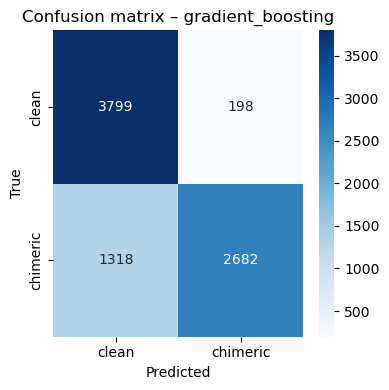


=== catboost ===
              precision    recall  f1-score   support

       clean     0.7429    0.9477    0.8329      3997
    chimeric     0.9279    0.6723    0.7796      4000

    accuracy                         0.8099      7997
   macro avg     0.8354    0.8100    0.8063      7997
weighted avg     0.8354    0.8099    0.8063      7997



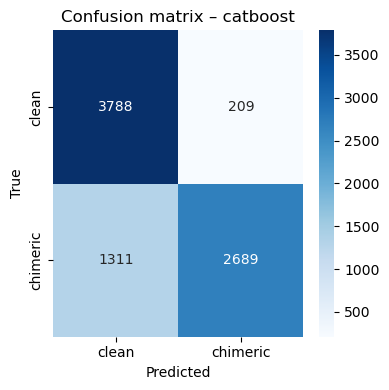


=== random_forest ===
              precision    recall  f1-score   support

       clean     0.7420    0.9405    0.8295      3997
    chimeric     0.9188    0.6733    0.7771      4000

    accuracy                         0.8068      7997
   macro avg     0.8304    0.8069    0.8033      7997
weighted avg     0.8304    0.8068    0.8033      7997



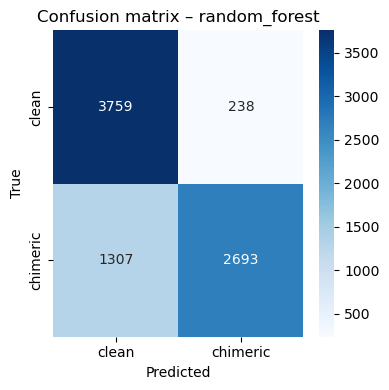

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # if you don't want seaborn, we can do pure matplotlib

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    print(classification_report(
        y_test, y_pred,
        target_names=["clean", "chimeric"],
        digits=4,
        zero_division=0,
    ))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["clean", "chimeric"],
                yticklabels=["clean", "chimeric"])
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

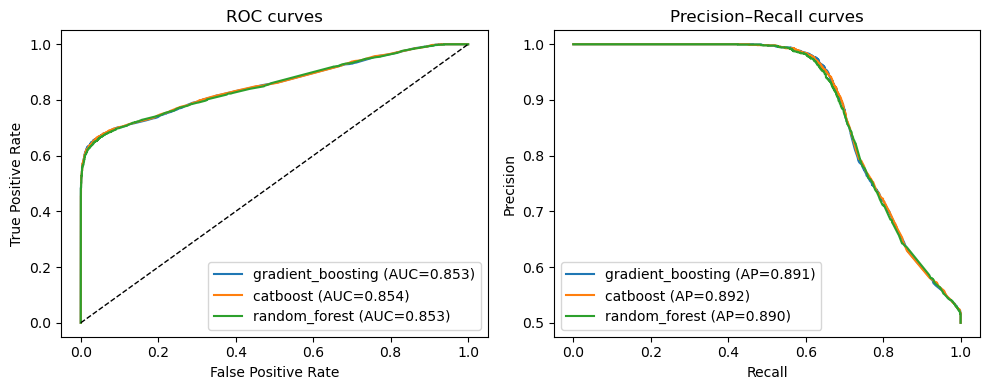

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

plt.figure(figsize=(10,4))

# ROC
plt.subplot(1,2,1)
for name, model in models.items():
    # scores: probas if available, else decision_function
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()

# PR
plt.subplot(1,2,2)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
    else:
        continue

    prec, rec, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.inspection import permutation_importance

def perm_importance(model, X, y, feature_names, scoring="f1", n_repeats=10):
    result = permutation_importance(
        model, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1,
        scoring=scoring,
    )
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }).sort_values("importance_mean", ascending=False)
    return df

imp_results = {}

for name, model in models.items():
    print(f"\n=== Permutation importance ({name}) ===")
    df_imp = perm_importance(model, X_test, y_test, feature_names, scoring="f1")
    imp_results[name] = df_imp


=== Permutation importance (gradient_boosting) ===

=== Permutation importance (catboost) ===

=== Permutation importance (random_forest) ===


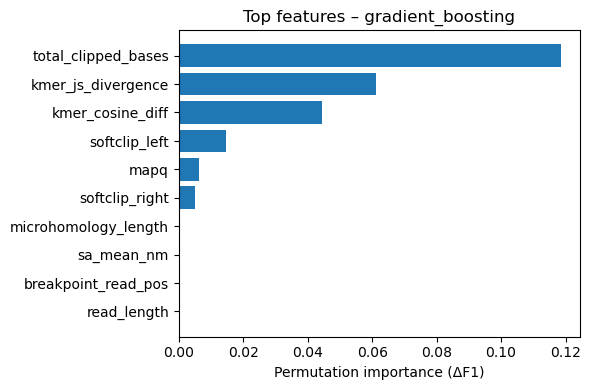

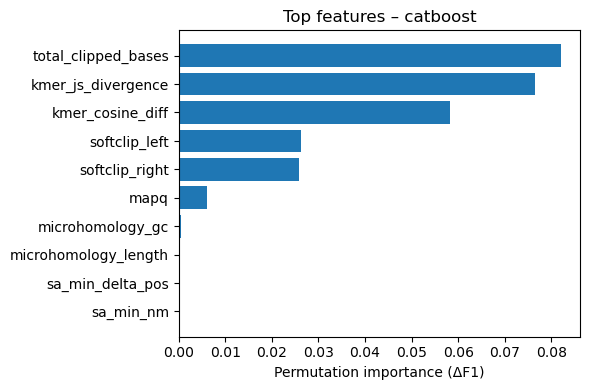

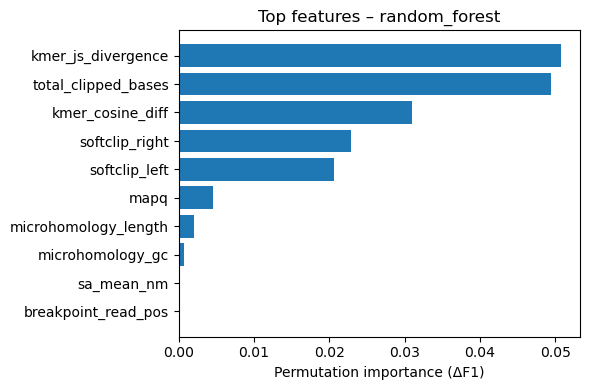

In [9]:
for name, df_imp in imp_results.items():
    top = df_imp.head(10).sort_values("importance_mean", ascending=True)

    plt.figure(figsize=(6,4))
    plt.barh(top["feature"], top["importance_mean"])
    plt.xlabel("Permutation importance (ΔF1)")
    plt.title(f"Top features – {name}")
    plt.tight_layout()
    plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Define which feature belongs to which family ---

family_map = {
    "SA_structure": [
        "has_sa",
        "sa_count",
        "num_segments",
        "sa_diff_contig",
        "sa_min_delta_pos",
        "sa_max_delta_pos",
        "sa_mean_delta_pos",
        "sa_same_strand_count",
        "sa_opp_strand_count",
        "sa_max_mapq",
        "sa_mean_mapq",
        "sa_min_nm",
        "sa_mean_nm",
    ],
    "Clipping": [
        "softclip_left",
        "softclip_right",
        "total_clipped_bases",
        "breakpoint_read_pos",
    ],
    "Kmer_jump": [
        "kmer_cosine_diff",
        "kmer_js_divergence",
    ],
    "Micro_homology": [
        "microhomology_length",
        "microhomology_gc",
    ],
    # optional: alignment quality / misc features
    "Other": [
        "mapq",      # alignment quality
        # add any remaining numeric features that don't fit above
        # e.g. "ref_start_1based" if it is still in your noq feature set
    ],
}

In [11]:
def aggregate_family_importance(df_imp: pd.DataFrame, family_map: dict) -> pd.DataFrame:
    """
    df_imp: DataFrame with columns ["feature", "importance_mean", "importance_std"]
    returns: DataFrame with one row per family, summing importance_mean of its features.
    """
    rows = []
    for fam, feats in family_map.items():
        sub = df_imp[df_imp["feature"].isin(feats)]
        if sub.empty:
            continue
        rows.append({
            "family": fam,
            "importance_sum": sub["importance_mean"].sum(),
            "importance_mean": sub["importance_mean"].mean(),
            "n_features": len(sub),
        })
    fam_df = pd.DataFrame(rows).sort_values("importance_sum", ascending=False)
    return fam_df

In [12]:
family_results = {}

for model_name, df_imp in imp_results.items():
    fam_df = aggregate_family_importance(df_imp, family_map)
    family_results[model_name] = fam_df
    print(f"\n=== Aggregated feature families – {model_name} ===")
    display(fam_df)


=== Aggregated feature families – gradient_boosting ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.138101,0.034525,4
2,Kmer_jump,0.105633,0.052817,2
4,Other,0.006149,0.006149,1
3,Micro_homology,0.000269,0.000134,2
0,SA_structure,-0.002113,-0.000163,13



=== Aggregated feature families – catboost ===


,family,importance_sum,importance_mean,n_features
2,Kmer_jump,0.134677,0.067338,2
1,Clipping,0.134250,0.033563,4
4,Other,0.006059,0.006059,1
3,Micro_homology,0.000868,0.000434,2
0,SA_structure,-0.003069,-0.000236,13



=== Aggregated feature families – random_forest ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.092989,0.023247,4
2,Kmer_jump,0.081677,0.040838,2
4,Other,0.004522,0.004522,1
3,Micro_homology,0.002743,0.001371,2
0,SA_structure,-0.001716,-0.000132,13


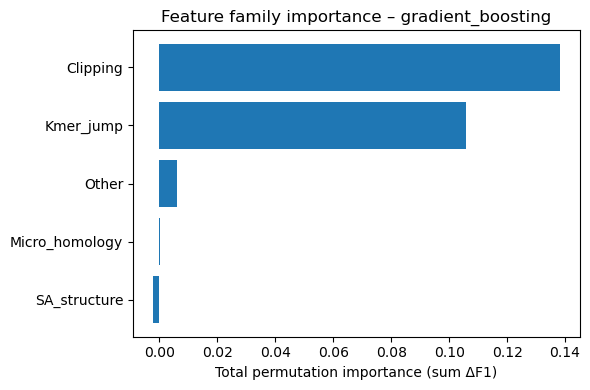

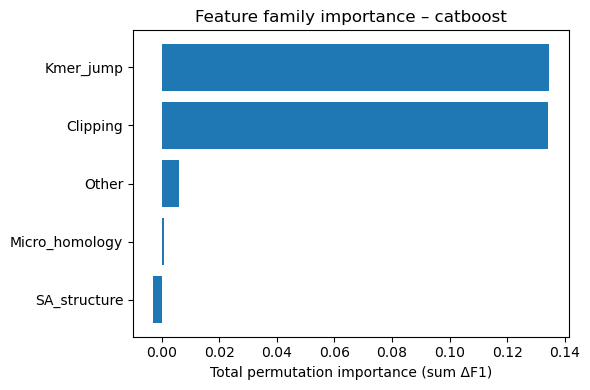

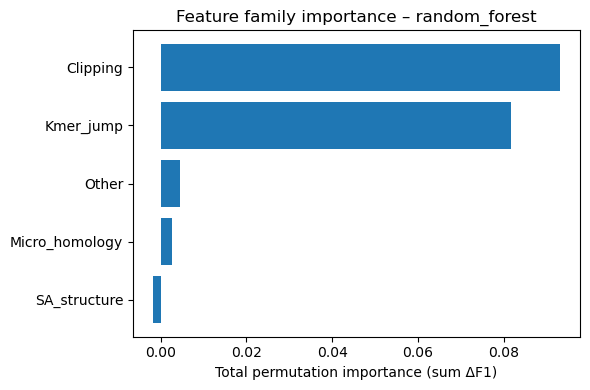

In [13]:
for model_name, fam_df in family_results.items():
    # sort so the smallest bar is at bottom
    fam_sorted = fam_df.sort_values("importance_sum", ascending=True)

    plt.figure(figsize=(6, 4))
    plt.barh(fam_sorted["family"], fam_sorted["importance_sum"])
    plt.xlabel("Total permutation importance (sum ΔF1)")
    plt.title(f"Feature family importance – {model_name}")
    plt.tight_layout()
    plt.show()